In [1]:
# Use with NHL_Model_Data_Transform_v5.py
import pandas as pd
import numpy as np
import seaborn as sns
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras



rng = 69

In [2]:
#df = pd.read_csv(r"C:\Users\zchodan\OneDrive - Franklin Templeton\Documents\Python\NHL_data\NHL_Data_Over_Under_Transformed.csv")
df_train = pd.read_csv(r"C:\Users\ZaneC\OneDrive\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums\train_transformed.csv")


In [3]:
df_train = df_train.drop('id',axis=1)

In [4]:
from sklearn.model_selection import train_test_split

# Split into 80% training data and 20% testing data

X = df_train.drop('Premium Amount', axis=1)
Y = df_train['Premium Amount'].copy()

X_train_initial, X_test, Y_train_initial, Y_test = train_test_split(X, Y, test_size=0.2, random_state=rng)

# Now split the training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_initial, Y_train_initial, test_size=0.25, random_state=rng)


Y_log_train = np.log1p(Y_train)
Y_log_val = np.log1p(Y_val)
Y_log_test = np.log1p(Y_test)

In [5]:
# Pipeline constructor used to run transformation steps in order
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

X_train_prepared= num_pipeline.fit_transform(X_train)
X_val_prepared= num_pipeline.fit_transform(X_val)
X_test_prepared= num_pipeline.fit_transform(X_test)


In [6]:
from keras import backend as K
from sklearn.metrics import mean_squared_log_error

#Define a custom RMSLE metric
def rmsle(y_true, y_pred):  
    # To avoid log(0), clip values to a small positive constant (epsilon)
    epsilon = tf.keras.backend.epsilon()

    # Apply log transformation
    #y_true_log = tf.math.log1p(y_true)  # Log-transform the true values
    #y_pred_log = tf.math.log1p(y_pred)  # Log-transform the clipped predicted values
    
    # RMSLE formula
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [7]:
from tensorflow import keras
from tensorflow.keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [8]:
n_epoch = 15

In [9]:
def build_model(n_neurons=144, n_hidden=5, dropout_rate=0, learning_rate=1e-3, input_shape=[X_train.shape[1]]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(shape=input_shape))
    # Hidden layer with droupout
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons,activation='relu'))
        model.add(keras.layers.Dropout(dropout_rate))
    # Output layer    
    model.add(keras.layers.Dense(1)) #, activation='relu'))
    
    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=[rmse])
    return model

In [10]:
from scikeras.wrappers import KerasRegressor

# Seems like you need to specify some items again when using the scikeras wrapper
keras_reg = KerasRegressor(model=build_model, n_hidden=1, n_neurons=30, learning_rate=3e-3)


In [12]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid


grid_param_distribs = {
    'model__n_hidden': [4,6,8],
    'model__dropout_rate': [0],
    'model__n_neurons': [(X_train.shape[1] * 2),(X_train.shape[1] * 4),(X_train.shape[1] * 5)], # Start with 2-4x the number of input features
    'model__learning_rate' : [.001]
}


grid_search_cv = GridSearchCV(keras_reg, grid_param_distribs, cv=3, scoring='neg_root_mean_squared_error',
                                   error_score = 'raise',verbose=1,n_jobs=os.cpu_count()-1)


early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

# Start timer
start_time = time.time()

grid_search_cv.fit(X_train_prepared,Y_log_train, epochs=n_epoch,
                 validation_data = (X_val_prepared, Y_log_val),
                 callbacks=[early_stopping_cb])

# End timer
end_time = time.time()

# def custom_print(params):
#     print(f"Training with params: {params}")

# for params in ParameterGrid(grid_param_distribs):
#     custom_print(params)
#     keras_reg.set_params(**params)
#     keras_reg.fit(
#         X_train_prepared,
#         Y_log_train,
#         epochs=n_epoch,
#         validation_data=(X_val_prepared, Y_log_val),
#         callbacks=[early_stopping_cb]
#     )



## Loss = MSLE score for training data
## rmsle = Difference between true and predicted value on a log scale for training data
## val_loss = MLSE for validation data, lower than training loss indicates performing well
## val_rmsle = Difference between true and predicted value on a log scale for validation data

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Epoch 1/15
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 23s 995us/step - loss: 1.3958 - rmse: 1.1581 - val_loss: 1.1701 - val_rmse: 1.0657
Epoch 2/15
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - loss: 1.1621 - rmse: 1.1035 - val_loss: 1.1605 - val_rmse: 1.0599
Epoch 3/15
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 22s 969us/step - loss: 1.1534 - rmse: 1.1064 - val_loss: 1.1795 - val_rmse: 1.0662
Epoch 4/15
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 22s 963us/step - loss: 1.1478 - rmse: 1.1071 - val_loss: 1.1499 - val_rmse: 1.0556
Epoch 5/15
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 22s 977us/step - loss: 1.1444 - rmse: 1.1080 - val_loss: 1.1524 - val_rmse: 1.0577
Epoch 6/15
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 22s 981us/step - loss: 1.1435 - rmse: 1.1082 - val_loss: 1.1499 - val_rmse: 1.0555
Epoch 7/15
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - loss: 1.1417 - rmse: 1.1107 - val_loss: 1.1459 - val_rmse: 1.0546
Epoch 8/15
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/ste

GridSearchCV(cv=3, error_score='raise',
             estimator=KerasRegressor(learning_rate=0.003, model=<function build_model at 0x000001FD1A619EE0>, n_hidden=1, n_neurons=30),
             n_jobs=15,
             param_grid={'model__dropout_rate': [0],
                         'model__learning_rate': [0.001],
                         'model__n_hidden': [4, 6, 8],
                         'model__n_neurons': [72, 144, 180]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [14]:
# Calculate duration in minutes
duration_minutes = (end_time - start_time) / 60
print(f"Total time for all iterations: {duration_minutes:.2f} minutes.")

Total time for all iterations: 0.00 minutes.


In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

rnd_param_distribs = {
    'model__n_hidden': [4,6,8],
    'model__dropout_rate': [0,.1],
    'model__n_neurons': np.arange((X_train.shape[1]*2),(X_train.shape[1] * 4)), # Start with 2-4x the number of input features
    'model__learning_rate' : reciprocal(1e-5, 1e-3)
}

rnd_search_cv = RandomizedSearchCV(keras_reg, rnd_param_distribs, n_iter=2, cv=2, scoring='neg_root_mean_squared_error',
                                   error_score = 'raise',n_jobs=os.cpu_count()-1)

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

# rnd_search_cv.fit(X_train_prepared,Y_log_train, epochs=n_epoch,
#                  validation_data = (X_val_prepared, Y_log_val),
#                  callbacks=[early_stopping_cb])


## Loss = MSLE score for training data
## rmsle = Difference between true and predicted value on a log scale for training data
## val_loss = MLSE for validation data, lower than training loss indicates performing well
## val_rmsle = Difference between true and predicted value on a log scale for validation data

In [15]:
print(grid_search_cv.best_params_)
print(grid_search_cv.best_score_)

{'model__dropout_rate': 0, 'model__learning_rate': 0.001, 'model__n_hidden': 4, 'model__n_neurons': 72}
-1.065181097757458


In [ ]:
## Best Parameters
## dropout_rate = 0
## learning_Rate = 0.001
## n_hidden = 4
## n_neurons = 144


In [16]:
best_model = grid_search_cv.best_estimator_.model

In [17]:
from scikeras.wrappers import KerasRegressor

# Seems like you need to specify some items again when using the scikeras wrapper
keras_reg = KerasRegressor(
    model=best_model,                   # Your pre-defined model
    epochs=n_epoch,                     # Number of epochs (how many times to train the model on the entire dataset)
    batch_size=5,                       # Number of samples per gradient update
    verbose=1,                          # Verbosity level (1: progress bar, 2: one line per epoch)
    random_state=rng,                   # Seed for random number generation to ensure reproducibility
    loss='mean_squared_error',          # Loss function used for training 
    optimizer=keras.optimizers.Adam(),  # Optimizer to update model weights
    metrics=[rmse],                     # Evaluation metric(s)
)

# Stop early if model is not getting better after # of patience epochs, restore to best model
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True, 
                                                  monitor='val_root_mean_squared_error')
#checkpoint_cb = keras.callbacks.ModelCheckpoint("Regression_Sequential.keras", save_best_only = True)

history = keras_reg.fit(X_train_prepared, Y_log_train, validation_data = (X_val_prepared, Y_log_val),
             callbacks=[early_stopping_cb])

Epoch 1/15
144000/144000 ━━━━━━━━━━━━━━━━━━━━ 149s 1ms/step - loss: 1.2702 - rmse: 1.0507 - val_loss: 1.1689 - val_rmse: 0.9791
Epoch 2/15
144000/144000 ━━━━━━━━━━━━━━━━━━━━ 156s 1ms/step - loss: 1.1653 - rmse: 1.0230 - val_loss: 1.1612 - val_rmse: 0.9746
Epoch 3/15
144000/144000 ━━━━━━━━━━━━━━━━━━━━ 156s 1ms/step - loss: 1.1592 - rmse: 1.0236 - val_loss: 1.1593 - val_rmse: 0.9744
Epoch 4/15
144000/144000 ━━━━━━━━━━━━━━━━━━━━ 154s 1ms/step - loss: 1.1574 - rmse: 1.0233 - val_loss: 1.1573 - val_rmse: 0.9765
Epoch 5/15
144000/144000 ━━━━━━━━━━━━━━━━━━━━ 156s 1ms/step - loss: 1.1554 - rmse: 1.0236 - val_loss: 1.1554 - val_rmse: 0.9749
Epoch 6/15
144000/144000 ━━━━━━━━━━━━━━━━━━━━ 159s 1ms/step - loss: 1.1543 - rmse: 1.0237 - val_loss: 1.1542 - val_rmse: 0.9747
Epoch 7/15
144000/144000 ━━━━━━━━━━━━━━━━━━━━ 159s 1ms/step - loss: 1.1529 - rmse: 1.0237 - val_loss: 1.1541 - val_rmse: 0.9748
Epoch 8/15
144000/144000 ━━━━━━━━━━━━━━━━━━━━ 157s 1ms/step - loss: 1.1526 - rmse: 1.0238 - val_loss: 1.

In [ ]:
from tensorflow.keras.models import load_model

# keras_reg.model_.save("Insurance_Regression - Best.keras")

# loaded_model = loaded_model("Insurance_Regression - Best.keras")
# keras_reg = KerasRegressor(model=loaded_model)

In [ ]:
# import matplotlib.pyplot as plt

# # Plot training and validation loss
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')

# # If you are monitoring RMSE or another metric:
# # plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
# # plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')

# plt.title('Training vs Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Overfitting: If the training loss decreases but the validation loss increases or plateaus, this might indicate overfitting.
# # Underfitting: If both training and validation loss are high, the model might not be learning well.
# # Convergence: If the curves are flattening out, it suggests that the model is converging

In [18]:
from sklearn.model_selection import cross_val_score

# Assuming X and y are your feature matrix and target vector
scores = cross_val_score(keras_reg, X_train_prepared, Y_log_train, cv=5, scoring='neg_root_mean_squared_error',verbose=0)

# Convert scores to positive values
mse_scores = -scores
print(f'MSE Scores: {mse_scores}')
print(f'Mean MSE: {np.mean(mse_scores)}')

Epoch 1/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 105s 906us/step - loss: 1.2907 - rmse: 1.0553
Epoch 2/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 105s 910us/step - loss: 1.1743 - rmse: 1.0224
Epoch 3/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 104s 907us/step - loss: 1.1646 - rmse: 1.0237
Epoch 4/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 104s 905us/step - loss: 1.1609 - rmse: 1.0241
Epoch 5/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 105s 913us/step - loss: 1.1600 - rmse: 1.0243
Epoch 6/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 107s 928us/step - loss: 1.1573 - rmse: 1.0241
Epoch 7/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 106s 917us/step - loss: 1.1566 - rmse: 1.0242
Epoch 8/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 106s 916us/step - loss: 1.1561 - rmse: 1.0240
Epoch 9/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 106s 922us/step - loss: 1.1552 - rmse: 1.0239
Epoch 10/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 106s 919us/step - loss: 1.1552 - rmse: 1.0237
Epoch 11/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 106s 916us/step - loss: 1.1543 -

115200/115200 ━━━━━━━━━━━━━━━━━━━━ 160s 1ms/step - loss: 1.1615 - rmse: 1.0216
Epoch 4/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 158s 1ms/step - loss: 1.1583 - rmse: 1.0212
Epoch 5/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 161s 1ms/step - loss: 1.1548 - rmse: 1.0216
Epoch 6/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 161s 1ms/step - loss: 1.1549 - rmse: 1.0211
Epoch 7/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 160s 1ms/step - loss: 1.1552 - rmse: 1.0208
Epoch 8/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 160s 1ms/step - loss: 1.1539 - rmse: 1.0209
Epoch 9/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 161s 1ms/step - loss: 1.1524 - rmse: 1.0210
Epoch 10/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 160s 1ms/step - loss: 1.1535 - rmse: 1.0209
Epoch 11/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 160s 1ms/step - loss: 1.1519 - rmse: 1.0209
Epoch 12/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 160s 1ms/step - loss: 1.1507 - rmse: 1.0208
Epoch 13/15
115200/115200 ━━━━━━━━━━━━━━━━━━━━ 158s 1ms/step - loss: 1.1501 - rmse: 1.0206
Epoch 14/15
11520

In [21]:
X_train_pred = keras_reg.predict(X_train_prepared)
X_test_pred = keras_reg.predict(X_test_prepared)

# Evaluate the model
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

rmse_train = root_mean_squared_error(Y_log_train, X_train_pred)
#mae = mean_absolute_error(Y_log_train, X_train_pred)

print(f'Train MSE: {rmse_train}') # Sensitive to outliers
#print(f'Train MAE: {mae}')

rmse_test = root_mean_squared_error(Y_log_test, X_test_pred)
#mae = mean_absolute_error(Y_log_test, X_test_pred)

print(f'Test MSE: {rmse_test}') # Sensitive to outliers
#print(f'Test MAE: {mae}')

Train MSE: 1.0642712215542873
Test MSE: 1.066196413930934


In [ ]:
## Current Record
##

In [22]:
#df_Predict = pd.read_csv(r"C:\Users\zchodan\OneDrive - Franklin Templeton\Documents\Python\NHL_data\NHL_Data_Over_Under_Predict.csv")
df_predict = pd.read_csv(r"C:\Users\ZaneC\OneDrive\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums\test_transformed.csv")

In [23]:
df_predict = df_predict.drop('id',axis=1)
X_predict = df_predict.values
X_predict_prepared = num_pipeline.fit_transform(X_predict)

Y_log_predict = keras_reg.predict(X_predict_prepared)

y_pred = np.expm1(Y_log_predict)  # Inverse of log1p (to get the original scale)

predictions_df = pd.DataFrame(y_pred, columns=['Predicted'])
predictions_df.to_csv('Predictions.csv', index=False)

160000/160000 ━━━━━━━━━━━━━━━━━━━━ 80s 498us/step


array([[<Axes: title={'center': 'Predicted'}>]], dtype=object)

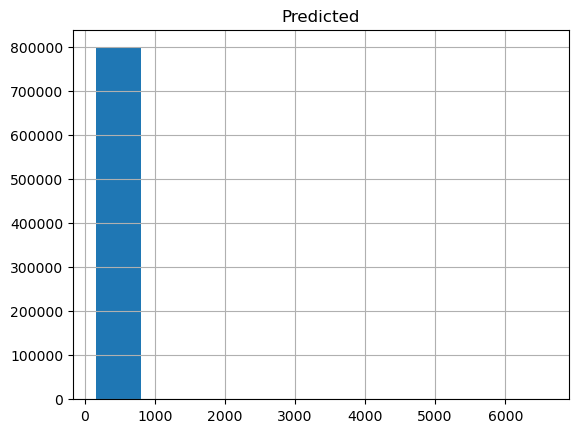

In [24]:
predictions_df.hist()